# Fake/Real Job Classification using Multinomial Naive Bayes

<h2>Introduction</h2>

<div style="text-align:justify">A company can advertise their needs in finding employees through job posting. Usually they display some information regarding job descriptions and criteria from applicants that must be met. However, not all job postings are real. There are some of them fakes. So applicants must be careful in sorting out the job posting.</div>
<div style="text-align:justify">To investigate whether job posting are real or fake, we can implement machine learning model classification. There are several model classification in machine learning, but if we want to predict some of categorical text, the most fit model can be used is Naive Bayes.</div>


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Data Wrangling</h2>

In [50]:
data = pd.read_csv("data_input/fake_job_postings.csv")

In [51]:
data.head(2)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


In [52]:
data.shape

(17880, 18)

In [53]:
data.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [54]:
data.drop(['job_id','location','department','salary_range'],inplace=True,axis=1)

In [55]:
#fill NA with blank space
column = ['company_profile', 'description', 'requirements', 'benefits']
for i in column:
    data[i] = data[i].fillna('')

In [56]:
column_ = ['employment_type','required_experience','required_education','industry','function']
for i in column_:
    data[i] = data[i].fillna('unknown')

<h2>Exploratory Data Analysis</h2>

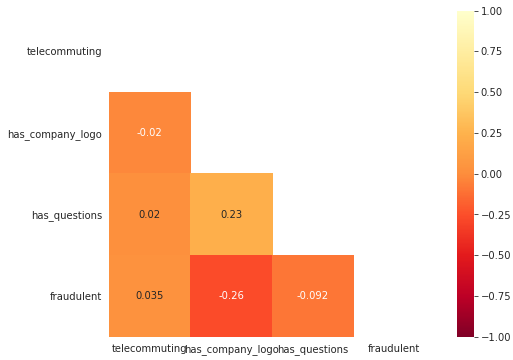

In [57]:
pd.set_option('precision', 3)
correlation=data.corr(method='pearson')
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 6))
    ax = sns.heatmap(correlation,mask=mask,square=True,annot=True,vmin=-1,vmax=1,cmap="YlOrRd_r")

In [58]:
employment_type = data['employment_type']
employment_type = employment_type[employment_type!='unknown']
popular_type_e = employment_type.value_counts()

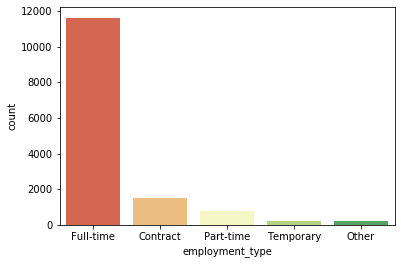

In [59]:
sns.countplot(x=employment_type, order=popular_type_e.index, palette="RdYlGn")

In [60]:
function = data['function']                
function = function[function!='unknown']
popular_job = function.value_counts().iloc[:10]

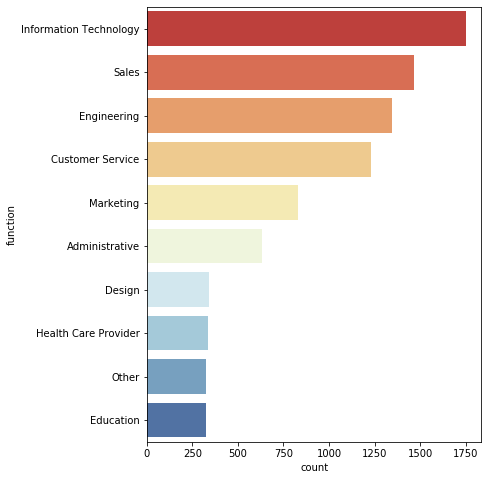

In [61]:
plt.figure(figsize=(6,8))
sns.countplot(y=function, order=popular_job.index, palette="RdYlBu")

In [62]:
data.loc[data["fraudulent"] == 0, "fraudulent"] = "Real"
data.loc[data["fraudulent"] == 1, "fraudulent"] = "Fake"


In [63]:
from collections import Counter
count1 = Counter(" ".join(data[data['fraudulent']=='Real']['company_profile']).\
                 split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in company profile real job", 1 : "count"})

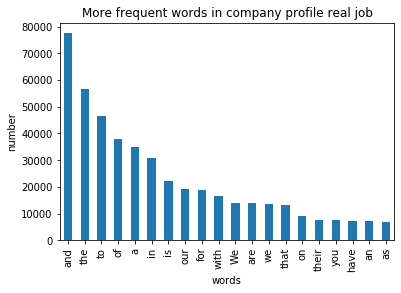

In [64]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in company profile real job"]))
plt.xticks(y_pos, df1["words in company profile real job"])
plt.title('More frequent words in company profile real job')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

In [65]:
count2 = Counter(" ".join(data[data['fraudulent']=='Fake']['description']).\
                 split()).most_common(20)
df2 = pd.DataFrame.from_dict(count1)
df2 = df2.rename(columns={0: "words in description real job", 1 : "count"})

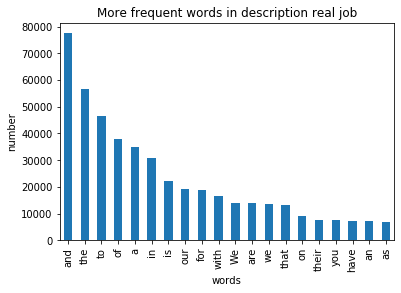

In [66]:
df2.plot.bar(legend = False)
y_pos = np.arange(len(df2["words in description real job"]))
plt.xticks(y_pos, df2["words in description real job"])
plt.title('More frequent words in description real job')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

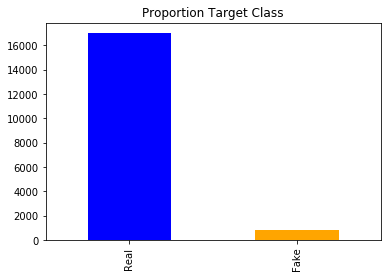

In [67]:
count_class=pd.value_counts(data["fraudulent"], sort= True)
count_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Proportion Target Class')
plt.show()

<h2>Text Mining</h2>

In [68]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\litaimut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [69]:
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')

In [70]:
text_df = data[['title','company_profile', 'description', 'requirements', 'benefits',\
          'employment_type','required_experience','required_education','industry','function']]
main_text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = data['fraudulent']

print(len(main_text))
print(len(target))

17880
17880


<h4>Remove Special Character</h4>

In [71]:
import re
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

main_text = main_text.apply(remove_between_square_brackets)
main_text = main_text.apply(remove_special_characters)


<h4>Tokenizer</h4>

In [72]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

main_text = main_text.apply(lambda x: tokenizer.tokenize(x))

<h4>Remove Stopwords</h4>

In [73]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopword_list]
    return words

main_text = main_text.apply(lambda x : remove_stopwords(x))

<h4>Join Text</h4>

In [74]:
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

main_text = main_text.apply(lambda x : combine_text(x))

df = pd.concat([main_text,target],axis=1)

In [75]:
df.rename(columns={0: "text"},inplace=True)

In [76]:
df.head(2)

,text,fraudulent
0,Marketing InternWere Food52 weve created groun...,Real
1,Customer Service Cloud Video Production90 Seco...,Real


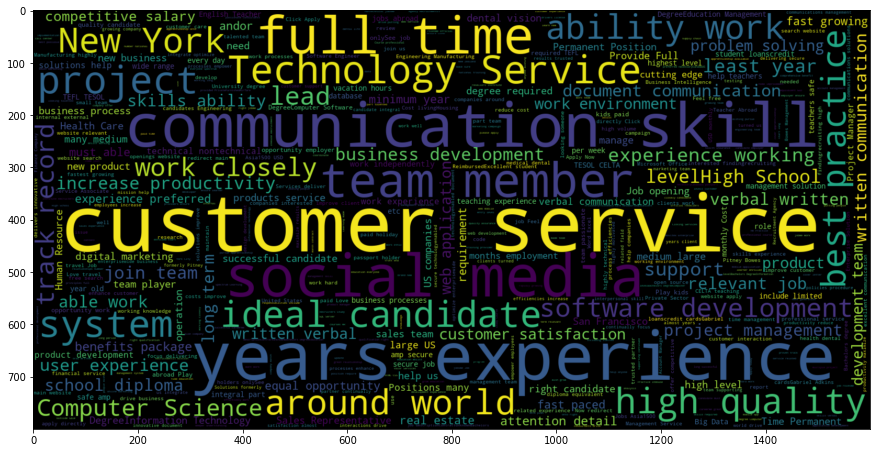

In [77]:
from wordcloud import WordCloud

plt.figure(figsize = (15,15)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.fraudulent == 'Real'].text))
plt.imshow(wc , interpolation = 'bilinear')

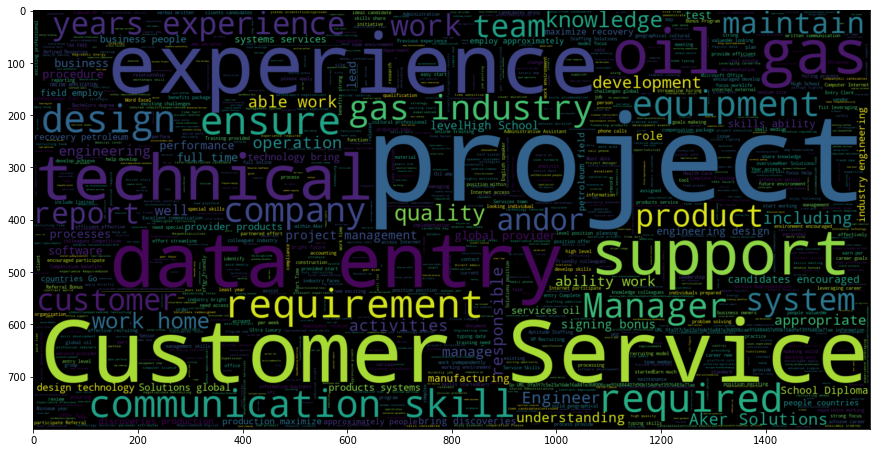

In [78]:
plt.figure(figsize = (15,15)) # Text that is fraudulent
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.fraudulent == 'Fake'].text))
plt.imshow(wc , interpolation = 'bilinear')

<h2>Modelling</h2>

<h4>Naive Bayes</h4>

In [79]:
from sklearn.model_selection import train_test_split
#setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(df.text, df.fraudulent, test_size=0.2, random_state=42)

In [80]:
from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))

cv_train=cv.fit_transform(X_train)
cv_test=cv.transform(X_test)

print('BOW_cv_train:',cv_train.shape)
print('BOW_cv_test:',cv_test.shape)

BOW_cv_train: (14304, 1844678)
BOW_cv_test: (3576, 1844678)


In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

tfidf_train=tfidf.fit_transform(X_train)

tfidf_test=tfidf.transform(X_test)
print('Tfidf_train:',tfidf_train.shape)
print('Tfidf_test:',tfidf_test.shape)

Tfidf_train: (14304, 1844678)
Tfidf_test: (3576, 1844678)


In [82]:
from sklearn.naive_bayes import MultinomialNB

#training the model
mnb=MultinomialNB()

mnb_bow=mnb.fit(cv_train,y_train)
print(mnb_bow)

mnb_tfidf=mnb.fit(tfidf_train,y_train)
print(mnb_tfidf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [83]:
mnb_bow_predict=mnb.predict(cv_test)

mnb_tfidf_predict=mnb.predict(tfidf_test)

In [84]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score

mnb_bow_score=accuracy_score(y_test,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)

mnb_tfidf_score=accuracy_score(y_test,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.939317673378076
mnb_tfidf_score : 0.9493847874720358


In [85]:
# print("Recall Score:",recall_score(y_test,mnb_bow_predict))
# print("Precision Score:",precision_score(y_test,mnb_bow_predict))

mnb_bow_report = classification_report(y_test,mnb_bow_predict)
print(mnb_bow_report)

              precision    recall  f1-score   support

        Fake       0.37      0.29      0.33       181
        Real       0.96      0.97      0.97      3395

    accuracy                           0.94      3576
   macro avg       0.67      0.63      0.65      3576
weighted avg       0.93      0.94      0.94      3576

